# initialize the workspace

## import relevant packages

In [30]:
# import packages
import numpy as np
import cv2
from skimage.measure import label, regionprops
from skimage import img_as_ubyte
import tifffile
import matplotlib.pyplot as plt

## import the test image
+ display it

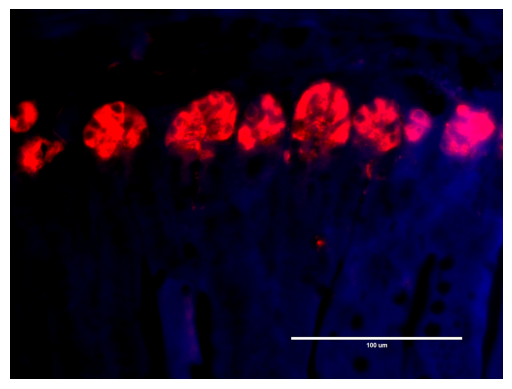

In [31]:
# class
class BlobDetector:
    def __init__(self, image_path):
        self.image_path = image_path
        self.raw_image = tifffile.imread(image_path)
        self.current_image = self.raw_image.copy()
        self.bar_mask = None
        self.binary_mask = None
        self.cleaned_mask = None
        self.blob_props = None
    def display(self, img=None):
        if img is None:
            img = self.current_image
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
# init class
image_path = "G2EB-RFP 40x-4.tif"
detector = BlobDetector(image_path)
detector.display()


# image preparation and processing

## prep class

In [32]:
class image_prep:
    class inconvenient_object_remover:
        def __init__(self, raw_image):
            self.raw_image = raw_image
        def remove_scale_bar(self, intensity_threshold=240, min_area=500, aspect_ratio_thresh=4.0):
            img = self.raw_image
            if img.ndim == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            else:
                gray = img.copy()
    
            _, binary = cv2.threshold(gray, intensity_threshold, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
            mask = np.ones_like(gray, dtype=np.uint8)
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                area = cv2.contourArea(cnt)
                aspect_ratio = max(w / h, h / w)
                if area > min_area and aspect_ratio > aspect_ratio_thresh:
                    cv2.rectangle(mask, (x, y), (x + w, y + h), 0, -1)
    
            self.bar_mask = mask
            if img.ndim == 3:
                self.current_image = cv2.merge([
                    cv2.bitwise_and(img[:, :, c], img[:, :, c], mask=mask)
                    for c in range(img.shape[2])
                ])
            else:
                self.current_image = cv2.bitwise_and(img, img, mask=mask)
            return self.current_image
    class select_image_channels:
        @staticmethod
        def red(img):
            
            if img.ndim == 3:
                current_image = img[:, :, 0]
            else:
                current_image = img.copy()
            return current_image
        @staticmethod
        def red_chromaticity(img):
            if img.ndim != 3:
                raise ValueError("Red chromaticity requires an RGB image.")
            R = img[:, :, 0].astype(float)
            G = img[:, :, 1].astype(float)
            B = img[:, :, 2].astype(float)
    
            epsilon = 1e-8  # Avoid division by zero
            sum_rgb = R + G + B + epsilon
            red_chroma = R / sum_rgb
    
            return (red_chroma * 255).astype(np.uint8)  # Scale back to 0-255 for image-like display
    class enhance_contrast:
        @staticmethod
        def CLAHE(img, clip_limit=2.0, tile_grid_size=(8,8)):
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
            img_8bit = img_as_ubyte(img / img.max())  # Normalize to 8-bit
            return clahe.apply(img_8bit)
        @staticmethod
        def enhance_nonblack(img, value=255):
            """
            Set all non-zero pixels in a grayscale image to a fixed value.
            Black (0) pixels remain black.

            Parameters:
            - img: Grayscale image as numpy array.
            - value: Brightness value to set (default 255).

            Returns:
            - Enhanced image.
            """
            # Ensure image is a numpy array
            img = np.asarray(img)

            # Create output array
            enhanced = np.zeros_like(img, dtype=np.uint8)

            # Set non-zero pixels to 'value'
            enhanced[img > 0] = value

            return enhanced
    class masker:            
        def __init__(self, image):
            self.current_image = image
        def otsu(self):
            _, binary = cv2.threshold(self.current_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            self.binary_mask = binary
            return self
        def morph_cleanup(self, kernel_size=5):
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
            cleaned = cv2.morphologyEx(self.binary_mask, cv2.MORPH_OPEN, kernel)
            cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
            self.cleaned_mask = cleaned
            return self
        
            
    

## remove scale bar

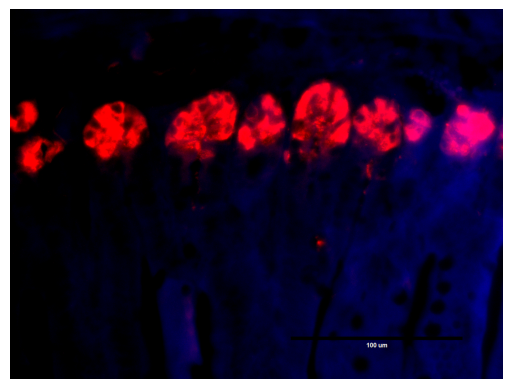

In [33]:
inconvenient_object_remover = image_prep.inconvenient_object_remover
detector.current_image = inconvenient_object_remover(detector.current_image).remove_scale_bar()
detector.display()

## select red chanel
this is bc the lysozyme stains fit nicely within the red channel, also removes the blue background

In [34]:
detector.red_chr_image = image_prep.select_image_channels.red_chromaticity(detector.current_image)
detector.red_image = image_prep.select_image_channels.red(detector.current_image)

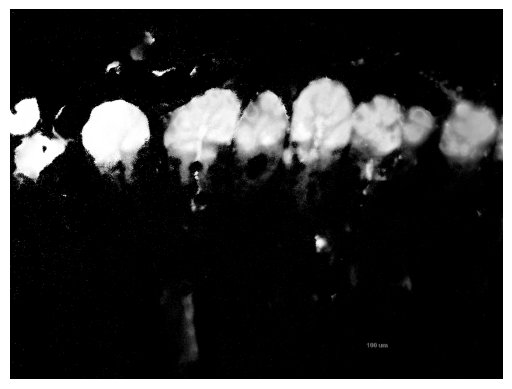

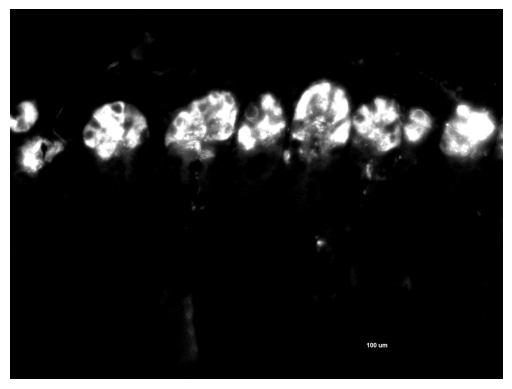

In [35]:
detector.display(img=detector.red_chr_image)
detector.display(img=detector.red_image)

## apply CLAHE
CLAHE stands for Contrast Limited Adaptive Histogram Equalization.

Let’s break that down:

Histogram Equalization is a method for adjusting image contrast by redistributing pixel intensities so they use the full available dynamic range (from black to white). It’s like stretching the histogram to make dark regions darker and bright regions brighter.

Adaptive means that instead of applying the same adjustment everywhere, CLAHE works in small regions of the image (called tiles or grid cells). This is important for images where brightness and contrast vary across different parts.

Contrast Limited means it avoids making the contrast too extreme in areas where the histogram is very concentrated (like in noisy regions). Without this, adaptive methods can produce weird artifacts like bright spots or speckles.

🎯 Why Do We Need CLAHE in the Code?
Your images (e.g., red channel from a tissue stain) might have:

Uneven lighting.

Varying contrast across different regions.

Faint signals in some areas that you want to enhance.

Simply applying a global contrast adjustment (like cv2.equalizeHist) might:

Overexpose bright regions.

Leave dark regions unchanged.

CLAHE helps by:
✅ Boosting contrast locally within each tile.
✅ Preserving details in both bright and dark regions.
✅ Reducing the risk of amplifying noise in homogeneous areas.

This makes it easier to detect blobs (your regions of interest) by:

Enhancing the signal where the stain is faint.

Making sure contrast is improved everywhere, not just globally.

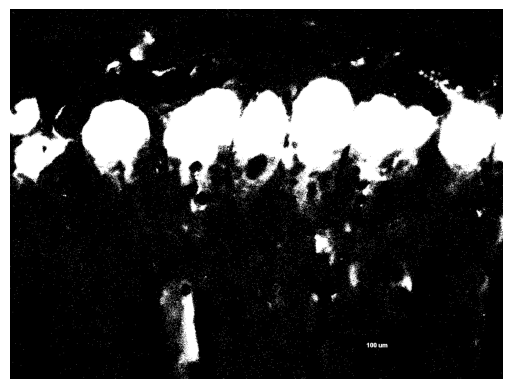

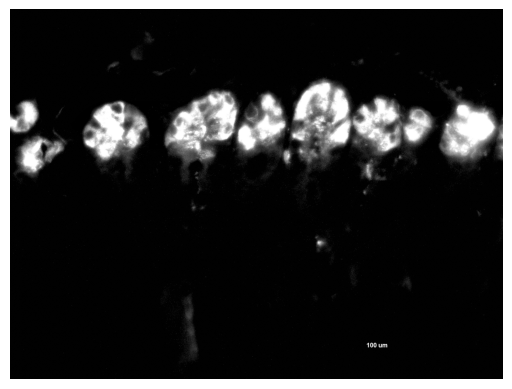

In [36]:
detector.red_chr_image = image_prep.enhance_contrast.enhance_nonblack(detector.red_chr_image)
detector.red_image = image_prep.enhance_contrast.CLAHE(detector.red_image)
detector.display(detector.red_chr_image)
detector.display(img=detector.red_image)
    

## binary mask
the goal of this is to create a binary mask that cleanly captures the boundries of the stained lysozyme regions

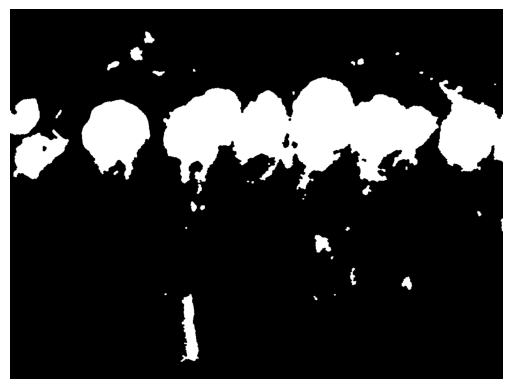

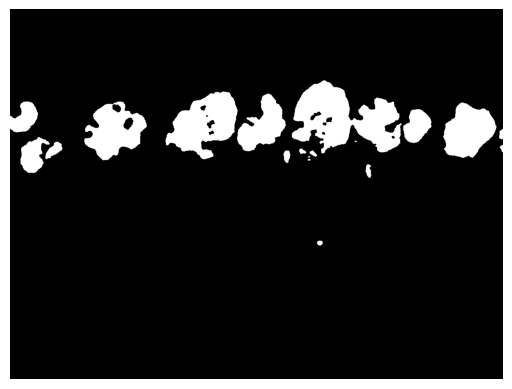

In [38]:
detector.chr_binary_mask = image_prep.masker(detector.red_chr_image).otsu().morph_cleanup().cleaned_mask
plt.imshow(detector.chr_binary_mask, cmap='gray')  # mask is your binary image
plt.axis('off')  # Optional: hide axis
plt.show()
detector.binary_mask = image_prep.masker(detector.red_image).otsu().morph_cleanup().cleaned_mask
plt.imshow(detector.binary_mask, cmap='gray')  # mask is your binary image
plt.axis('off')  # Optional: hide axis
plt.show()


# extract blobs
following the image processing creating a representative binary map, we will use said binary map to identify broader boundries of the things

## blob handler class

In [39]:
class blob_handler:
    def __init__(self, binary_mask, current_image=None):
        self.binary_mask =  binary_mask
        if current_image is not None:
            self.current_image = current_image
    def extract_blobs(self, top_n=5):
        self.label_img = label(self.binary_mask)
        props = regionprops(self.label_img)
        self.blob_props = sorted(props, key=lambda x: x.area, reverse=True)[:top_n]
        
        return self
    def draw_blobs(self, on_image=None):
        if on_image is None:
            on_image = self.current_image
        blobs = self.blob_props
        self.blobs_on_image = cv2.cvtColor(on_image, cv2.COLOR_GRAY2BGR) if on_image.ndim == 2 else on_image.copy()

        for i, blob in enumerate(blobs):
            minr, minc, maxr, maxc = blob.bbox
            cv2.rectangle(self.blobs_on_image, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
            cy, cx = blob.centroid
            cv2.putText(self.blobs_on_image, f"{i+1}", (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        return self
    
    

## code explainations

### self.blob_props
🧭 What is self.blob_props?
✅ It’s a list of regionprops objects from skimage.measure.regionprops.
✅ Each object in the list represents one detected blob (a connected region of non-zero pixels in your binary mask).
✅ These blobs are sorted by area (largest first) and limited to the top N blobs (default: 5).

🎯 How Does It Get Created?
Here’s the flow:

```
self.label_img = label(self.binary_mask)  # Labels connected components in the mask
props = regionprops(self.label_img)       # Extracts blob properties for each labeled region
self.blob_props = sorted(props, key=lambda x: x.area, reverse=True)[:top_n]
```
📦 What’s Inside Each Blob (regionprops object)?
Each blob object in self.blob_props contains rich information about the detected blob.
For example, each blob has:

| Attribute      | Meaning                                                  | Example                       |
| -------------- | -------------------------------------------------------- | ----------------------------- |
| `area`         | Number of pixels in the blob                             | 1203                          |
| `bbox`         | Bounding box (min\_row, min\_col, max\_row, max\_col)    | (45, 100, 150, 210)           |
| `centroid`     | Center coordinates (row, col)                            | (97.5, 155.2)                 |
| `coords`       | List of pixel coordinates                                | Array of shape (N, 2)         |
| `eccentricity` | How elongated the blob is                                | 0.85                          |
| `perimeter`    | Blob perimeter                                           | 145.3                         |
| `intensity_*`  | If using `intensity_image`, mean/centroid intensity etc. | (with `current_image` passed) |


✅ You can access these like:

python
Copy
Edit
for blob in self.blob_props:
    print(blob.area, blob.centroid, blob.eccentricity)
🧠 In Plain Language
✅ self.blob_props is your list of detected blobs.
✅ Each blob is a region object with properties like:

Size (area)

Location (centroid, bounding box)

Shape (eccentricity, perimeter)

Pixel coordinates (coords)

✅ It’s like having a spreadsheet of blob measurements you can use for analysis or drawing.

## blob implementation

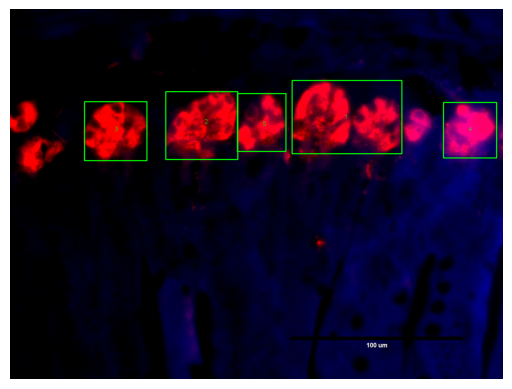

In [40]:
blobs = blob_handler(binary_mask=detector.binary_mask,current_image=detector.current_image).extract_blobs().draw_blobs().blobs_on_image
plt.imshow(blobs, cmap='gray')  # mask is your binary image
plt.axis('off')  # Optional: hide axis
plt.show()